# ML Recommender System project

Useful libraries to import:

In [4]:
from proj2_helpers import *
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

## 1. Data Loading

In [76]:
def convert_ID(string):
    """Convert the string ID of the form 'r44_c1' into the user_id 44 and movie_id 1"""
    remove_chars = string.replace("r","").replace("c", "").replace("_", " ")
    split = remove_chars.split()
    user_id = int(split[0])
    movie_id = int(split[1])
    return user_id, movie_id

def load_csv_data(data_path, nb_users, nb_movies):
    """Loads data and returns the rating matrix"""
    X = np.genfromtxt(data_path, dtype= str, delimiter=',', skip_header = True)
    ratings_matrix = np.zeros((nb_users, nb_movies), dtype=np.int)
    ids = np.zeros((len(X), 2), dtype=np.int)
    
    for i in range(X.shape[0]):
        user_id, movie_id = convert_ID(X[i][0])
        ids[i] = [user_id, movie_id]
        ### Check for errors
        if(user_id > 0 and user_id <= nb_users and movie_id > 0 and movie_id <= nb_movies):
            ### Use -1 because IDs start at 1 and we want them to start at 0
            ratings_matrix[user_id - 1][movie_id - 1] = int(X[i][1])
        else:
            print("Error with user {} and movie {}".format(user_id, movie_id))
    return ratings_matrix, ids

def movie_user_predictions(sample_matrix):
    """Compute the matrix of indices we want to predict with movies as rows and users 
    for which we want to predict the rating for this movie"""
    result = []
    movie_user_matrix = sample_matrix.T
    for movie_ratings in movie_user_matrix:
        user_indices = [user for user, rating in enumerate(movie_ratings) if rating != 0]
        result.append(user_indices)
    return np.array(result)

Load the data. We also need the sample ids as those are the ratings that we want to predict.

In [61]:
nb_users = 10000
nb_movies = 1000
print("Loading data")
ratings_matrix, ids = load_csv_data("data_train.csv", nb_users, nb_movies)
print("Loading sample")
sample_matrix, sample_ids = load_csv_data("sample_submission.csv", nb_users, nb_movies)

Loading data
Loading sample


In [82]:
ratings_to_predict = movie_user_predictions(sample_matrix)

In [83]:
print(ratings_to_predict[0][:5])
print(sample_ids[:5])

[36, 72, 155, 159, 247]
[[ 37   1]
 [ 73   1]
 [156   1]
 [160   1]
 [248   1]]


## 2. Statistics on the data

In [10]:
mean = np.mean(ratings_matrix[ratings_matrix != 0])
print("Mean of the ratings: {}".format(mean))
sparsity = 100 * (1 - (len(ratings_matrix[ratings_matrix != 0]) / (nb_users * nb_movies)))
print("Sparsity of the matrix: {}%".format(sparsity))
ratings_per_user = np.count_nonzero(ratings_matrix, axis = 1)
ratings_per_movie = np.count_nonzero(ratings_matrix, axis = 0)
print("The median of ratings amount per user is {}".format(np.median(ratings_per_user)))
print("The median of ratings amount per movie is {}".format(np.median(ratings_per_movie)))
print("Minimum ratings: {}, Maximum ratings: {}".format(min(ratings_per_user), max(ratings_per_user)))

Mean of the ratings: 3.8572805008190647
Sparsity of the matrix: 88.23048%
The median of ratings amount per user is 104.0
Minimum ratings: 3, Maximum ratings: 522


Distribution of the value of ratings:

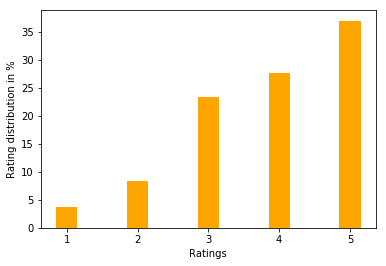

[ 43508  99180 274327 324700 435237]
[1 2 3 4 5 6]


In [11]:
distrib_ratings, bins_ratings = np.histogram(ratings_matrix[ratings_matrix != 0], bins = [1, 2, 3, 4, 5, 6])
percentages_ratings = 100 * distrib_ratings / np.sum(distrib_ratings)

plt.bar(bins_ratings[:-1], percentages_ratings, width = 0.3, color = 'orange')
plt.xlabel("Ratings")
plt.ylabel("Rating distribution in %")
plt.show()

print(distrib_ratings)
print(bins_ratings)

Distribution of number of ratings:

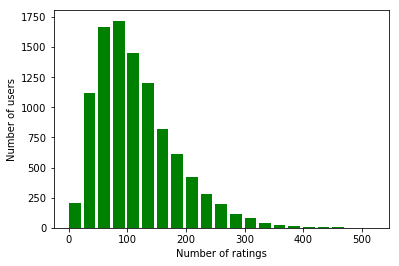

In [12]:
### Compute number of movies seen by each user
movies_rated = np.count_nonzero(ratings_matrix, axis = 1)

distrib_movies, bins_movies = np.histogram(movies_rated, bins = range(0,550,25))
plt.bar(bins_movies[:-1], distrib_movies, width = 20, color = 'green', align = 'edge')
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.show()

## 3. Algorithms

The recommender system designed through this project uses the User-User Collaborative Filtering method. Collaborative filtering (CF) is a popular recommendation algorithm that bases the predictions and recommendations on the past ratings of users in the system. Thus, User-user CF consists of finding other users whose past rating behavior is similar to the one of the current user and uses their ratings on other items to predict what the current user will like.

To compute the predictions for each user in the algorithm, we need a similarity function $s(u, v)$ computing the similarity between two users: u and v. The similarity function is used to compute a neighborhood $\mathbf{K} \subseteq U$ for each user u that consists of the K users that are most similar to u. Finally, the predicted rating for user u and movie i will be computed using the set of neighbors $\mathbf{K}$ , as follows:
    
$$p_{u, i} = \frac{\sum_{v \in \mathbf{K}} s(u, v) . r_{v,i}}{\sum_{v \in \mathbf{K}} |s(u, v)|}$$
    
where ${r}_{v,i}$ is the rating user v gave to movie i

### 3.1 Similarity functions

We need a similarity function to compute all similarities between users or movies, we will try the following functions:
    - cosine similarity
    - euclidean distance
    - pearson correlation

#### 3.1.1 Cosine similarity

Users are represented as $I$-dimensional vectors and the similarity is computed by taking their dot product divided by the product of their Euclidean norms:
    
$$s(u,v) = \frac{\mathbf{r}_{u}.\mathbf{r}_{v}}{\lVert \mathbf{r}_{u} \rVert_{2} \lVert \mathbf{r}_{v} \rVert_{2}} = \frac{\sum_{i} r_{u,i}.r_{v,i}}{\sqrt{\sum_{i} r_{u,i}^2} \sqrt{\sum_{i} r_{v,i}^2}} $$
    
where $\mathbf{r}_{u}$ and $\mathbf{r}_{v}$ are the rating vectors of user $u$ and $v$ respectively. Unknown ratings are considered to be $0.0$ and this causes them to drop out of the numerator.

In [13]:
from sklearn.metrics import pairwise_distances

### similarity = 1 - distance
cosine_matrix = np.ones((nb_users, nb_users)) - sk.metrics.pairwise_distances(ratings_matrix, metric='cosine')
### Set to 0 the similarity from user to itself
cosine_matrix -= np.identity(nb_users)
cosine_matrix

array([[ 0.        ,  0.09836635,  0.20147319, ...,  0.05138538,
         0.19649248,  0.17267498],
       [ 0.09836635,  0.        ,  0.12758677, ...,  0.05600622,
         0.22168764,  0.24500193],
       [ 0.20147319,  0.12758677,  0.        , ...,  0.10204437,
         0.23786563,  0.20604448],
       ..., 
       [ 0.05138538,  0.05600622,  0.10204437, ...,  0.        ,
         0.14194186,  0.21796069],
       [ 0.19649248,  0.22168764,  0.23786563, ...,  0.14194186,
         0.        ,  0.18952854],
       [ 0.17267498,  0.24500193,  0.20604448, ...,  0.21796069,
         0.18952854,  0.        ]])

#### 3.1.2 Euclidean Distance

#### 3.1.3 Pearson Correlation

### 3.2 K-nearest neighbors

In [14]:
def getTopKNeighbors(similarities, K):
    """Given the similarities of a user as an array, only keep the K best (max) similarities
       by setting other similarities to 0"""
    copy = np.copy(similarities)
    index = len(similarities) - K
    # Get the similarity value of the K best neighbor
    bestNeighborsVal = np.partition(similarities, index)[index]
    low_values_indices = copy < bestNeighborsVal # Where values are below the threshold
    copy[low_values_indices] = 0.0
    return copy

In [53]:
test = getTopKNeighbors(cosine_matrix[1], 100)
len(test[test != 0])

100

### 3.3 Predict the ratings

The following methods uses a different neighborhood for each user and item: the neighbors must have seen the movie that we want to predict

Compute all predictions user per user:

In [242]:
"""Too long for computation as it computes all predictions: 10 millions"""
### similarities is the array of similarities for the considered user
### ratings is the transpose ratings_matrix (movies x users)
### K_best is the number of best neighbors (integer)
def compute_predictions(ratings_movie_user, similarities, K_best):
    """Compute all the predictions for a particular user"""
    # Create matrix with same columns of similarities with length of ratings_movie_user as the number of columns
    copiedSimilarities = np.tile(similarities, (len(ratings_movie_user), 1)).T
    # Set similarities to 0.0 when the other users haven't rated the movie (don't take them in consideration for calculus)
    copiedRatings = np.copy(ratings_movie_user) #This copy is really really important !!!
    copiedRatings[copiedRatings != 0.0] = 1.0
    copiedSimilarities = np.multiply(copiedSimilarities, ratings_movie_user.T)
    
    # Apply function getTopNNeighbors to each column of copiedSimilarities
    bestNeighbors = np.apply_along_axis(getTopKNeighbors, 0, copiedSimilarities, K_best)
    # Get a list of sums of each column of copiedSimilarities
    sumSimilarities = np.sum(bestNeighbors, axis = 0)

    #Compute prediction: dot product of the items in partialRatings @ similarities of K best neighbors -> just get diagonal values
    predictions = np.einsum('ij,ji->i', ratings_movie_user, bestNeighbors)
    predictions = predictions / sumSimilarities
    predictions[np.isnan(predictions)] = 0.0
    return predictions

In [243]:
"""Too long for computation as it computes all predictions: 10 millions"""
def compute_matrix(ratings_matrix, similarity_matrix, K_best):
    """Compute the matrix of predictions by running the compute_predictions for each user"""
    nb_users = len(ratings_matrix)
    nb_movies = len(ratings_matrix[0])
    predictions_matrix = np.zeros((nb_users, nb_movies))
    for user in range(nb_users):
        if(user%100 == 0):
            print(user)
        similarities_user = similarity_matrix[user]
        predictions_user = compute_predictions(np.copy(ratings_matrix).T, similarities_user, K_best)
        predictions_matrix[user] = predictions_user
    return predictions_matrix

In [248]:
### This cell only for testing:
preds_test = compute_predictions(np.copy(ratings_matrix).T, cosine_matrix[36], 100)
preds_test

array([ 4.54324212,  4.60861297,  4.88102289,  5.        ,  4.95293621,
        5.        ,  4.95393599,  5.        ,  4.4613122 ,  5.        ,
        4.96149018,  4.61802447,  4.64064601,  5.        ,  4.97987434,
        4.88740051,  4.84013087,  4.15409638,  4.85258086,  4.906893  ,
        5.        ,  4.93330472,  4.77831891,  4.87040958,  4.8112198 ,
        5.        ,  4.82330761,  4.76100714,  4.95304526,  4.990789  ,
        4.34527446,  4.99049836,  5.        ,  4.86102955,  4.79809704,
        4.20434277,  5.        ,  4.48687281,  3.93977225,  4.98159892,
        3.07013611,  4.98136038,  4.89873734,  5.        ,  5.        ,
        5.        ,  4.25567443,  4.99081252,  3.76293544,  4.60142872,
        5.        ,  4.3555217 ,  4.97183566,  4.32872013,  4.99067058,
        3.39743368,  4.91811147,  3.5162759 ,  5.        ,  5.        ,
        5.        ,  4.60296054,  4.96268449,  4.76663116,  4.7380959 ,
        4.81395211,  4.46278671,  4.99052687,  5.        ,  4.50

Compute predictions for each movie:

In [235]:
### ratings_matrix: The ratings matrix with dimension movies x users
### movie: Index of movie we want to predict (from 0 to 9999)
### similarity_matrix: The similarity matrix between al users
### users_to_predict: The list of users (indices) for which we want to compute the predictions
### K_best: The number of neighbors to keep for each prediction 
def compute_predictions_movie(ratings_matrix, movie, similarity_matrix, users_to_predict, K_best):
    """Compute all the wanted predictions for the given movie and returns the predictions in an array"""
    ratings = ratings_matrix[movie]
    # Following steps: only keep the similarities (user) if they have seen the movie
    copiedRatings = np.tile(ratings, (len(users_to_predict), 1))
    copiedRatings[copiedRatings != 0] = 1
    # Get similarity matrix of the wanted users with dimension: all users (10000) x wanted users(< 10000)
    similarities = similarity_matrix[users_to_predict].T
    similarities = np.multiply(similarities, copiedRatings.T)
    
    # Apply function getTopKNeighbors to each column of similarities to keep K best similarities for each user
    bestNeighbors = np.apply_along_axis(getTopKNeighbors, 0, similarities, K_best)
    # Get a list of sums of each column of bestNeighbors
    sumSimilarities = np.sum(bestNeighbors, axis = 0)

    #Compute prediction: dot product of the items in ratings @ bestNeighbors divided by the corresponding sum of similarities
    predictions = np.dot(ratings, bestNeighbors)
    predictions = predictions / sumSimilarities
    predictions[np.isnan(predictions)] = 0.0
    return predictions

In [236]:
def compute_matrix_predictions(ratings_matrix, ratings_to_predict, similarity_matrix, K_best):
    """Compute the wanted predictions by running the compute_predictions_movie for each movie"""
    nb_users = len(ratings_matrix)
    nb_movies = len(ratings_matrix[0])
    movie_user_matrix = ratings_matrix.T 
    predictions = []
    ### Compute wanted predictions for wanted users
    for movie in range(nb_movies):
        if(movie % 100 == 0):
            print("Percentage: {}".format(100*movie/nb_movies))
        users_to_predict = ratings_to_predict[movie]
        predictions_movie = compute_predictions_movie(movie_user_matrix, movie, similarity_matrix, users_to_predict, K_best)
        predictions.append(predictions_movie)
    return predictions

In [188]:
predictions_matrix = compute_matrix_predictions(ratings_matrix, ratings_to_predict, cosine_matrix, 100)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


## 4. Submission

In [222]:
def convert_ids_for_submission(ids):
    result = []
    for id_ in ids:
        newId = 'r'+str(id_[0])+'_c'+str(id_[1])
        result.append(newId)
    return result

In [232]:
def create_csv_submission(ids, pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (ids of user,movies we want to predict)
               pred (predicted ratings)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames, lineterminator = '\n')
        writer.writeheader()
        for r1, r2 in zip(ids, pred):
            writer.writerow({'Id':str(r1),'Prediction':float(r2)})

In [224]:
ids_sub = convert_ids_for_submission(sample_ids)

In [238]:
### Flatten the matrix row by row into a list of predictions
preds = [p for movie_preds in predictions_matrix for p in movie_preds]
### Create csv submission
print(len(ids_sub), len(preds))
create_csv_submission(ids_sub, preds, "user-userCF.csv")

1176952 1176952
